# Tabnet Hyperoptimization

In [1]:
import pandas as pd
from load_data import *
from matplotlib import pyplot as plt
%matplotlib inline
import tabnet
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import os
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import KFold

ModuleNotFoundError: No module named 'load_data'

In [4]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  
  return r2

In [5]:
def transform(ds):
    features = tf.unstack(ds["features"])
    prices = ds["price"]

    x = dict(zip(col_names, features))
    y = prices
    return x, y

## Selected Variables

### Output and Feature Dimension
Output and Feature dimension have a large impact on performance, so do the optimization only concerning them

In [2]:
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
# remove extreme prices
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
filter = price < 500
listings = listings[filter]
X_train, _ = train_test_split(listings, random_state = 123, test_size = 0.2)
X_train = X_train.reset_index(drop = True)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blanke

What I want to Grid search for

In [3]:
ods = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120] 
fds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
overview_mae = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_mse = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_r2 = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_mae.columns = fds
overview_mae.index = ods
overview_mse.columns = fds
overview_mse.index = ods
overview_r2.columns = fds
overview_r2.index = ods

In [ ]:
kf = KFold(n_splits=5)
cv_run = 0
fold_data = {}

In [8]:
for i in ods:
    for j in fds:
        
        mae_min = []
        mse_min = []
        r2_max = []

        kf = KFold(n_splits=5, shuffle=True, random_state=1234)
        for train_index, test_index in kf.split(X_train):
            c = 0    
            print("TRAIN:", train_index, "TEST:", test_index)

            # Data
            if cv_run > 0:
                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = fold_data[str(c)]
            else:
                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_cv(for_dendro=True, train_idx = train_index, val_idx = test_index)
            

            bin_col = [col for col in X_train_kf if np.isin(X_train_kf[col].unique(), [0, 1]).all()]
            num_col = [col for col in X_train_kf if ~np.isin(X_train_kf[col].unique(), [0, 1]).all()]
            col_names = bin_col + num_col

            train_size = int(X_train_kf.shape[0] * 0.9)
            batch_size = int(X_train_kf.shape[0] * 0.1)

            data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
            data_train = data_train.shuffle(6000, seed = 13)
            train_dataset = data_train.take(len(X_train_kf))
            train_dataset = train_dataset.map(transform)
            train_dataset = train_dataset.batch(batch_size)

            data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
            test_dataset = data_test.take(len(X_val_kf))
            test_dataset = test_dataset.map(transform)
            test_dataset = test_dataset.batch(batch_size)

            feature_columns = []

            for col in col_names:
                feature_columns.append(tf.feature_column.numeric_column(col))


            model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=i, feature_dim=i+j, num_groups=1,
                                            num_decision_steps=2)
                                            
            lr = 0.01
            optimizer = tf.keras.optimizers.Adam(lr)
            model.compile(optimizer, loss=['mse'] , metrics=[R_squared, "mse", "mae"])

            hist_model = model.fit(train_dataset, epochs=50, 
                                validation_data=test_dataset, verbose=1)

            mae_min.append(np.min(hist_model.history["val_mae"]))
            mse_min.append(np.min(hist_model.history["val_mse"]))
            r2_max.append(np.max(hist_model.history["val_R_squared"]))

            # save fold data
            if cv_run == 0:
                fold_data[str(c)] = [X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf]
            c += 1

        cv_run += 1
        mae_min_m = np.mean(mae_min)
        mse_min_m = np.mean(mse_min)
        r2_max_m = np.mean(r2_max)

        overview_mae.at[i, j] = mae_min_m
        overview_mse.at[i, j] = mse_min_m
        overview_r2.at[i, j] = r2_max_m

TRAIN: [   1    2    3 ... 5309 5310 5311] TEST: [   0    8   14 ... 5301 5302 5306]
[TabNet]: 1 features will be used for decision steps.
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 2s 225ms/step - loss: 6.7287 - R_squared: -13.3807 - mse: 6.7287 - mae: 2.0818 - val_loss: 1.1313 - val_R_squared: -1.4261 - val_mse: 1.1313 - val_mae: 0.8951
Epoch 2/50
11/11 [==============================] - 1s 74ms/step - loss: 0.6599 - R_squared: -0.5383 - mse: 0.6599 - mae: 0.6578 - val_loss: 0.4706 - val_R_sq

In [ ]:
fds_ind = ["+1", "+2", "+3", "+4", "+5", "+6", "+7", "+8", "+9", "+10"] # for a better labeling of the resulting heatmap
overview_mae.columns = fds_ind
overview_mse.columns = fds_ind
overview_r2.columns = fds_ind

In [ ]:
overview_mae.to_csv("TabNet_GS_all_1_mae.csv")
overview_mse.to_csv("TabNet_GS_all_1_mse.csv")
overview_r2.to_csv("TabNet_GS_all_1_r2.csv")

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


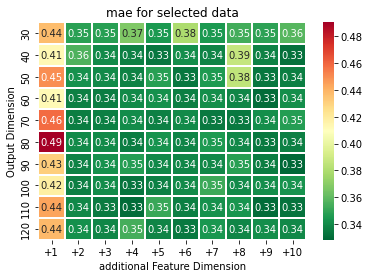

In [13]:
sns.heatmap(overview_mae, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for all variables")
plt.xlabel("additional Feature Dimension")
plt.ylabel("Output Dimension")
plt.savefig("TabNet_GS_all_1_mae", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


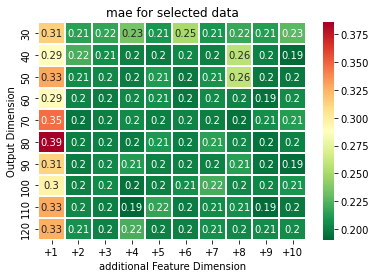

In [14]:
sns.heatmap(overview_mse, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for all variables")
plt.xlabel("additional Feature Dimension")
plt.ylabel("Output Dimension")
plt.savefig("TabNet_GS_all_1_mse", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


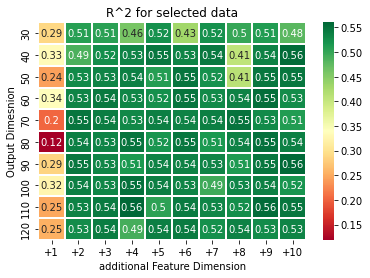

In [15]:
sns.heatmap(overview_r2, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for all variables")
plt.xlabel("additional Feature Dimension")
plt.ylabel("Output Dimension")
plt.savefig("TabNet_GS_all_1_r2", drpi = 300)

In [ ]:
best_idx = np.unravel_index(np.argmax(overview_mr2, axis=None), overview_mr2.shape)
od = ods[best_idx[0]]
fd = od + fds[best_idx[1]]

Now steps and relaxation factor.

In [9]:
nds = [2, 3, 4, 5, 6, 7, 8, 9, 10]
rf = [1, 1.5, 2, 2.5, 3, 3.5]

In [11]:
overview_mae_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_mse_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_r2_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_mae_2.columns = rf
overview_mae_2.index = nds
overview_mse_2.columns = rf
overview_mse_2.index = nds
overview_r2_2.columns = rf
overview_r2_2.index = nds

In [ ]:
kf = KFold(n_splits=5)
#cv_run = 0

In [ ]:
for i in nds:
    for j in rf:
        
        mae_min = []
        mse_min = []
        r2_max = []
           
        
        kf = KFold(n_splits=5, shuffle=True, random_state=1234)
        for train_index, test_index in kf.split(X_train):
            c = 0   
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = fold_data[str(c)]

            train_size = int(X_train_kf.shape[0] * 0.9)
            batch_size = int(X_train_kf.shape[0] * 0.1)

            data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
             data_train = data_train.shuffle(6000, seed = 13)
            train_dataset = data_train.take(len(X_train_kf))
            train_dataset = train_dataset.map(transform)
            train_dataset = train_dataset.batch(batch_size)

            data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
            test_dataset = data_test.take(len(X_val_kf))
            test_dataset = test_dataset.map(transform)
            test_dataset = test_dataset.batch(batch_size)

            feature_columns = []

            for col in col_names:
                feature_columns.append(tf.feature_column.numeric_column(col))

            model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=od, feature_dim=fd, num_groups=1,
                                            num_decision_steps=i, relaxation_factor=j)
                                            
            lr = 0.01
            optimizer = tf.keras.optimizers.Adam(lr)
            model.compile(optimizer, loss=['mse'] , metrics=[R_squared, "mse", "mae"])

            hist_model = model.fit(train_dataset, epochs=50,
                                validation_data=test_dataset, verbose=1)

            mae_min.append(np.min(hist_model.history["val_mae"]))
            mse_min.append(np.min(hist_model.history["val_mse"]))
            r2_max.append(np.max(hist_model.history["val_R_squared"]))
            c += 1


        mae_min_m = np.mean(mae_min)
        mse_min_m = np.mean(mse_min)
        r2_max_m = np.mean(r2_max)

        overview_mae_2.at[i, j] = mae_min_m
        overview_mse_2.at[i, j] = mse_min_m
        overview_r2_2.at[i, j] = r2_max_m

In [9]:
overview_mae_2.to_csv("TabNet_GS_all_2_mae.csv")
overview_mse_2.to_csv("TabNet_GS_all_2_mse.csv")
overview_r2_2.to_csv("TabNet_GS_all_2_r2.csv")

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


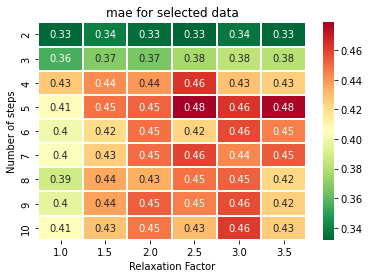

In [13]:
sns.heatmap(overview_mae_2, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for all data")
plt.xlabel("Relaxation Factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_GS_all_2_mae.png", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


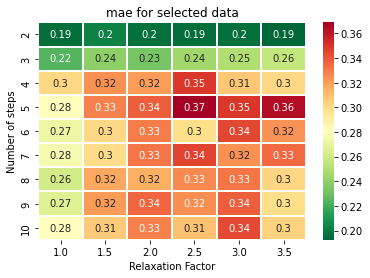

In [14]:
sns.heatmap(overview_mse_2, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for all variables")
plt.xlabel("Relaxation Factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_GS_all_2_mse.png", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


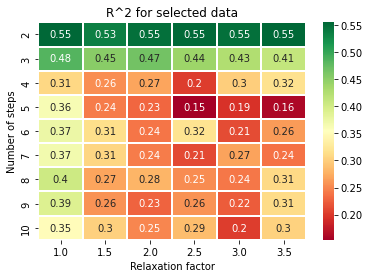

In [16]:
sns.heatmap(overview_r2_2, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for all variables")
plt.xlabel("Relaxation factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_GS_all_2_r2.png", drpi = 300)

In [ ]:
best_idx = np.unravel_index(np.argmax(overview_r2_2, axis=None), overview_r2_2.shape)
nds = nds[best_idx[0]]
rf = rf[best_idx[1]]

In [31]:
sc = [ 1e-2, 1e-3, 1e-4, 1e-5]
overview_mae_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_mse_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_r2_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_mae_3.columns = sc
overview_mse_3.columns = sc
overview_r2_3.columns = sc

In [32]:
for j in sc:
        
    mae_min = []
    mse_min = []
    r2_max = []

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_index, test_index in kf.split(X_train):
        print("TRAIN:", train_index, "TEST:", test_index)
        c = 0   
        X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = fold_data[str(c)]

        train_size = int(X_train_kf.shape[0] * 0.9)
        batch_size = int(X_train_kf.shape[0] * 0.1)

        data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
        data_train = data_train.shuffle(6000, seed = 13)
        train_dataset = data_train.take(len(X_train_kf))
        train_dataset = train_dataset.map(transform)
        train_dataset = train_dataset.batch(batch_size)

        data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
        test_dataset = data_test.take(len(X_val_kf))
        test_dataset = test_dataset.map(transform)
        test_dataset = test_dataset.batch(batch_size)

        feature_columns = []

        for col in col_names:
            feature_columns.append(tf.feature_column.numeric_column(col))

        model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=od, feature_dim=fd, num_groups=1,
                                            num_decision_steps=nds, relaxation_factor=rf,
                                            sparsity_coefficient=j)
                                            
        lr = 0.01
        optimizer = tf.keras.optimizers.Adam(lr)
        model.compile(optimizer, loss=['mse'] , metrics=[R_squared, "mse", "mae"])

        hist_model = model.fit(train_dataset, epochs=50,
                                validation_data=test_dataset, verbose=1)

        mae_min.append(np.min(hist_model.history["val_mae"]))
        mse_min.append(np.min(hist_model.history["val_mse"]))
        r2_max.append(np.max(hist_model.history["val_R_squared"]))
        c += 1

    mae_min_m = np.mean(mae_min)
    mse_min_m = np.mean(mse_min)
    r2_max_m = np.mean(r2_max)

    overview_mae_3.at[0, j] = mae_min_m
    overview_mse_3.at[0, j] = mse_min_m
    overview_r2_3.at[0, j] = r2_max_m

TRAIN: [   1    2    3 ... 5309 5310 5311] TEST: [   0    8   14 ... 5301 5302 5306]
[TabNet]: 4 features will be used for decision steps.
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 2s 203ms/step - loss: 3.7133 - R_squared: -6.7467 - mse: 3.7133 - mae: 1.3157 - val_loss: 0.6720 - val_R_squared: -0.4446 - val_mse: 0.6720 - val_mae: 0.6682
Epoch 2/50
11/11 [==============================] - 1s 78ms/step - loss: 0.4695 - R_squared: -0.0962 - mse: 0.4695 - mae: 0.5465 - val_loss: 0.4937 - val_R_squ

In [39]:
overview_mae_3.to_csv("TabNet_GS_sall_3_mae.csv")
overview_mse_3.to_csv("TabNet_GS_all_3_mse.csv")
overview_r2_3.to_csv("TabNet_GS_all_3_r2.csv")

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


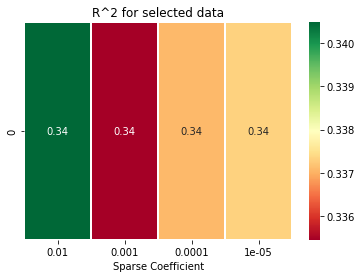

In [36]:
sns.heatmap(overview_mae_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("mae for all variables")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")
plt.savefig("TabNet_GS_all_3_mae.png", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


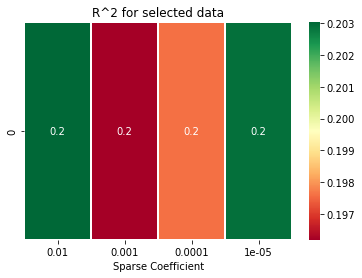

In [37]:
sns.heatmap(overview_mse_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("mse for all variables")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")
plt.savefig("TabNet_GS_all_3_mse.png", drpi = 300)

C:\Users\49173\anaconda3\envs\DL_tabnet\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "drpi" which is no longer supported as of 3.3 and will become an error in 3.6
  """


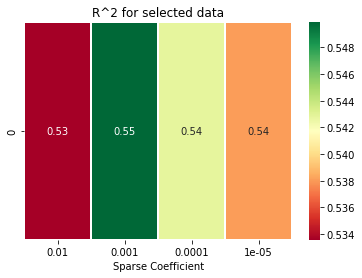

In [38]:
sns.heatmap(overview_r2_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for all variables")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")
plt.savefig("TabNet_GS_all_3_r2.png", drpi = 300)

In [ ]:
best_idx = np.unravel_index(np.argmax(overview_r2_3, axis=None), overview_r2_3.shape)
sc = sc[best_idx[1]]

# Final Model

In [20]:
print("Best Output Dimension: ", od)
print("Best Feature Dimension: ", fd)
print("Best Number of steps: ", nds)
print("Best relaxation factor: ", rf)
print("Best sparsity coefficient: ", sc)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blanke

In [30]:
mae_min = []
mse_min = []
r2_max = []
c = 0  
epo = 100

kf = KFold(n_splits=5, shuffle=True, random_state=1234)
for train_index, test_index in kf.split(X_train):
    print(c)
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = fold_data[str(c)]

    train_size = int(X_train_kf.shape[0] * 0.9)
    batch_size = int(X_train_kf.shape[0] * 0.1)

    data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
    data_train = data_train.shuffle(6000, seed = 13)
    train_dataset = data_train.take(len(X_train_kf))
    train_dataset = train_dataset.map(transform)
    train_dataset = train_dataset.batch(batch_size)

    data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
    test_dataset = data_test.take(len(X_val_kf))
    test_dataset = test_dataset.map(transform)
    test_dataset = test_dataset.batch(batch_size)

    feature_columns = []

    for col in col_names:
        feature_columns.append(tf.feature_column.numeric_column(col))

    model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                    output_dim=od, feature_dim=fd, num_groups=1,
                                    num_decision_steps=nds, relaxation_factor=rf,
                                    sparsity_coefficient=sc)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f"TabNet_GS/best_model_all{c}.hdf5",
                                                    monitor='val_R_squared',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode='max')
                                            
    lr = 0.01
    optimizer = tf.keras.optimizers.Adam(lr)
    model.compile(optimizer, loss=['mse'] , metrics=[R_squared, "mse", "mae"])

    hist_model = model.fit(train_dataset, epochs=epo,
                           validation_data=test_dataset, verbose=1,
                            callbacks=[checkpoint])

    print("Fitted model", c+1)
    mae_min.append(np.min(hist_model.history["val_mae"]))
    mse_min.append(np.min(hist_model.history["val_mse"]))
    r2_max.append(np.max(hist_model.history["val_R_squared"]))

    if c > 0:
        if mae_min[c] < mae_min[c -1]:
            X_train_bestfold = X_train_kf
            X_val_bestfold = X_val_kf
            y_train_bestfold = y_train_kf
            y_val_bestfold = y_val_kf

    hist_df = pd.DataFrame(hist_model.history)
    hist_csv_file = f'history_TabNet_all_final{c}.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    print("Saved.")
    c += 1

print("The minimum mae is", np.min(mae_min), "and got achieved at the", np.argmin(mae_min) + 1, "model.")
print("The minimum mse is", np.min(mse_min), "and got achieved at the", np.argmin(mse_min) + 1, "model.")
print("The maximum R2 is", np.max(r2_max), "and got achieved at the", np.argmax(r2_max) + 1, "model.")

0
TRAIN: [   1    2    3 ... 5845 5846 5847] TEST: [   0    5    8 ... 5830 5837 5842]
[TabNet]: 4 features will be used for decision steps.
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/11 [==========================>...] - ETA: 0s - loss: 2.6401 - R_squared: -5.3070 - mse: 2.6401 - mae: 1.1187
Epoch 00001: val_R_squared improved from -inf to -0.17463, saving model to TabNet_GS\best_model0.hdf5
11/11 [==============================] - 3s 308ms/step - loss: 2.6361 - R_squared: -4.8642 - mse: 2.6361 - mae: 1.1175 - val_loss: 0.5167 - 

In [35]:
X_train_bestfold.to_csv("TabNet_BestTrain.csv")
X_val_bestfold.to_csv("TabNet_BestVal.csv")
y_train_bestfold.to_csv("TabNet_BestTrainY.csv")
y_val_bestfold.to_csv("TabNet_BestValY.csv")

In [ ]:
Force an error to load the correct history

In [32]:
hist_model5 = pd.read_csv("TabNet_GS/ ??? .csv")

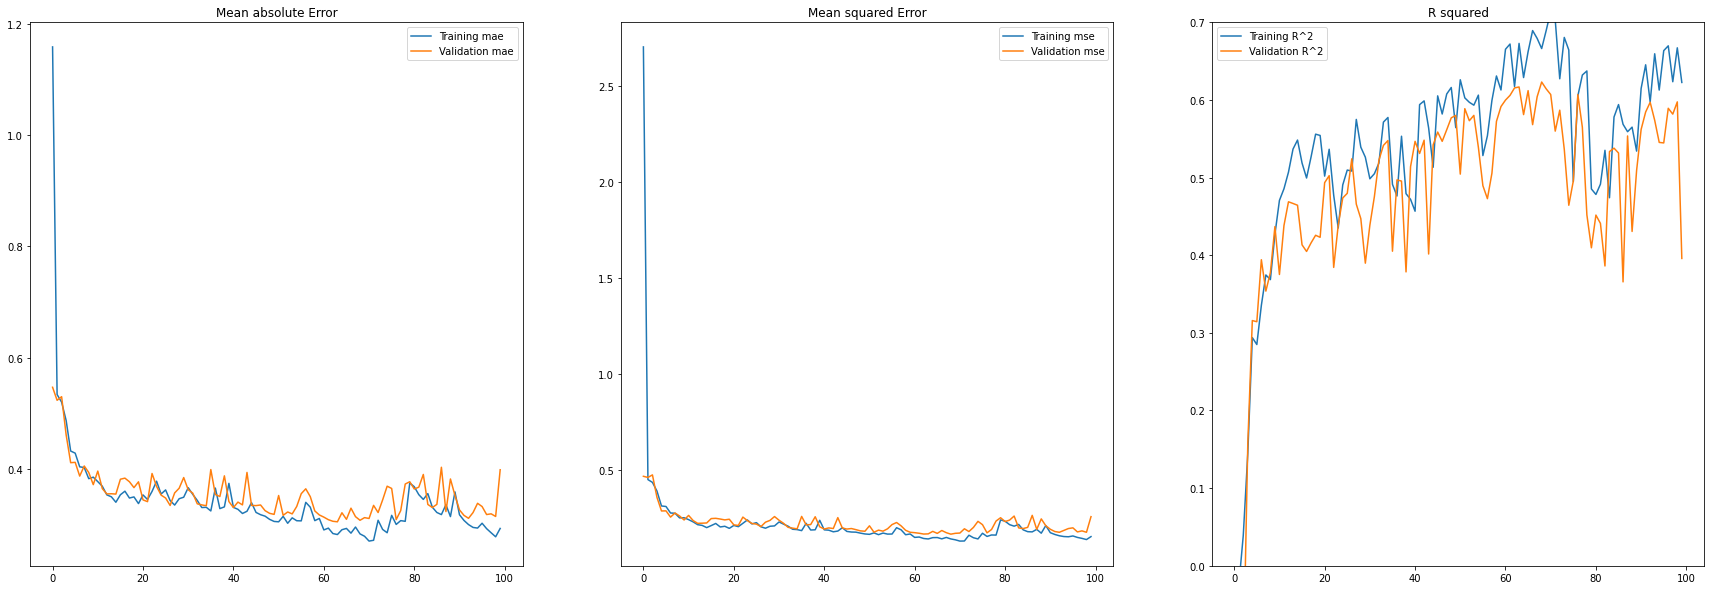

In [34]:
epochs_range = range(epo)
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].plot(epochs_range, hist_model5["mae"], label="Training mae")
axs[0].plot(epochs_range, hist_model5["val_mae"], label="Validation mae")
axs[0].set_title("Mean absolute Error")
axs[0].legend(loc='best')

axs[1].plot(epochs_range, hist_model5["mse"], label="Training mse")
axs[1].plot(epochs_range, hist_model5["val_mse"], label="Validation mse")
axs[1].set_title("Mean squared Error")
axs[1].legend(loc='best')

axs[2].plot(epochs_range, hist_model5["R_squared"], label="Training R^2")
axs[2].plot(epochs_range, hist_model5["val_R_squared"], label="Validation R^2")
axs[2].set_ylim((0, 0.7))
axs[2].set_title("R squared")
#axs[2].axhline(y = 0.6, color = "red")
axs[2].legend(loc='best')

plt.savefig("TabNet_GS/TabNet_Selected_Final.png")

# Load best model

In [36]:
X_train = pd.read_csv("TabNet_BestTrain.csv")
X_val = pd.read_csv("TabNet_BestVal.csv")
y_train = pd.read_csv("TabNet_BestTrainY.csv")
y_val = pd.read_csv("TabNet_BestValY.csv")
del X_train["Unnamed: 0"]
del X_val["Unnamed: 0"]
del y_train["Unnamed: 0"]
del y_val["Unnamed: 0"]

In [37]:
def transform(ds):
    features = tf.unstack(ds["features"])
    prices = ds["price"]

    x = dict(zip(col_names, features))
    y = prices
    return x, y

def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  
  return r2

bin_col = [col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all()]
num_col = [col for col in X_train if ~np.isin(X_train[col].unique(), [0, 1]).all()]
col_names = bin_col + num_col

train_size = int(X_train.shape[0] * 0.9)
batch_size = int(X_train.shape[0] * 0.1)

data_train = tf.data.Dataset.from_tensor_slices({"features": X_train, "price": y_train})
data_train = data_train.shuffle(6000, seed = 13)
train_dataset = data_train.take(len(X_train))
train_dataset = train_dataset.map(transform)
train_dataset = train_dataset.batch(batch_size)

data_test = tf.data.Dataset.from_tensor_slices({"features": X_val, "price": y_val})
test_dataset = data_test.take(len(X_val))
test_dataset = test_dataset.map(transform)
test_dataset = test_dataset.batch(batch_size)


feature_columns = []

for col in col_names:
    feature_columns.append(tf.feature_column.numeric_column(col))


od = ???
fd = ???
nds = ???
rf = ???
epo = 1

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100, decay_rate=0.95, staircase=False)
#lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                output_dim=od, feature_dim=fd, num_groups=1,
                                num_decision_steps=nds, relaxation_factor=rf)

model.compile(optimizer, loss=['mse', "mae"] , metrics=[R_squared, "mse", "mae"])

hist_model = model.fit(train_dataset, epochs=epo, 
                        validation_data=test_dataset, verbose=1)

model.load_weights("TabNet_GS/ ??? .hdf5")

[TabNet]: 4 features will be used for decision steps.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 4s 328ms/step - loss: 4.2697 - R_squared: -8.0891 - mse: 4.2697 - mae: 1.4153 - val_loss: 0.8065 - val_R_squared: -0.9359 - val_mse: 0.8065 - val_mae: 0.7321


In [38]:
model.summary()

Model: "tab_net_regressor_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tab_net_13 (TabNet)          multiple                  148272    
_________________________________________________________________
regressor (Dense)            multiple                  110       
Total params: 148,382
Trainable params: 148,382
Non-trainable params: 0
_________________________________________________________________
Model: "tab_net_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_13 (DenseFeat multiple                  0         
_________________________________________________________________
input_gn (GroupNormalization multiple                  132       
_________________________________________________________________
transform_block_91 (Transfor multiple                  15504     
____________________

In [39]:
data_testing = tf.data.Dataset.from_tensor_slices({"features": X_test, "price": y_test})
testing_dataset = data_testing.take(len(X_test))
testing_dataset = testing_dataset.map(transform)
testing_dataset = testing_dataset.batch(X_test.shape[0])

In [40]:
y_pred = model.predict(testing_dataset)

In [41]:
model.evaluate(testing_dataset, verbose=1)

1/1 [==============================] - 0s 1ms/step - loss: 0.1756 - R_squared: 0.5578 - mse: 0.1756 - mae: 0.3145


[0.17558513581752777,
 0.5577843189239502,
 0.17558513581752777,
 0.31450650095939636]

# Shap Values for best model

In [42]:
import shap

In [43]:
# define pipeline function
def f(x):
  tmp = pd.DataFrame(x, columns = X_test.columns)
  tmp = tmp.to_dict("series")
  return(model.predict(tmp))

In [44]:
# masker and explainer 
masker = shap.maskers.Independent(X_test.values, max_samples=100)
explainer = shap.explainers.Permutation(f, masker)

In [45]:
# compute shap_values
shap_values = explainer(X_test.values)

# adjust base_value
shap_values.base_values = shap_values.base_values[0][0]
shap_values.feature_names = X_test.columns

Permutation explainer: 1322it [5:03:27, 13.78s/it]                            


In [46]:

# function to alter shap_values
def get_aggr_shap(values):
    
    feat = values.feature_names 
    filter = pd.Series(feat).str.contains(r"_pca").values
    feat_pca = np.array(feat)[filter].tolist()
    
    splits = np.unique(pd.Series(feat_pca).str.split((r"_pca\d|_pca$"), expand = True).values[:,0])
    new_feat = values.feature_names
    new_values = values.values
    new_data = values.data
    for i in splits:
        regex_filter = pd.Series(new_feat).str.contains(i).values
        # drop feature names
        new_feat = np.array(new_feat)[~regex_filter].tolist()
        new_feat.append(i)
        
        # aggregated values
        values_filtered = new_values[:,np.where(regex_filter)[0].tolist()]   
        values_aggr = values_filtered.sum(axis = 1)
        # drop values
        new_values = new_values[:,  np.where(~regex_filter)[0].tolist()]
        #new_values = np.concatenate((new_values, values_aggr), axis = 0)
        new_values = np.c_[new_values, values_aggr]
        
        # alter data matrix
        new_data = new_data[:,  np.where(~regex_filter)[0].tolist()]
        new_data = np.c_[new_data, np.repeat(np.NaN,new_data.shape[0])]

    values.feature_names=new_feat
    values.values = new_values
    values.data = new_data
    #values.data[:,-len(splits):] = np.full((values.data.shape[0], len(splits)), np.NaN)
    
    # replace data of non pca variables with actual values
    col_raw = X_test_no.columns.tolist()
    col_shap = values.feature_names
    col_new = []
    for i in col_raw:
        if i in col_shap:
            col_new.append(i)
    
    for i in col_new:
        index_shap = np.where(np.array(col_shap) == i)
        values.data[:,index_shap] = X_test_no[i].values.reshape((X_test_no[i].values.shape[0],1,1))
    
    
    
    return values


In [47]:

X_train_no,X_test_no,_,_,_,_ = load_data(for_dendro=True, standardize=False)





------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds

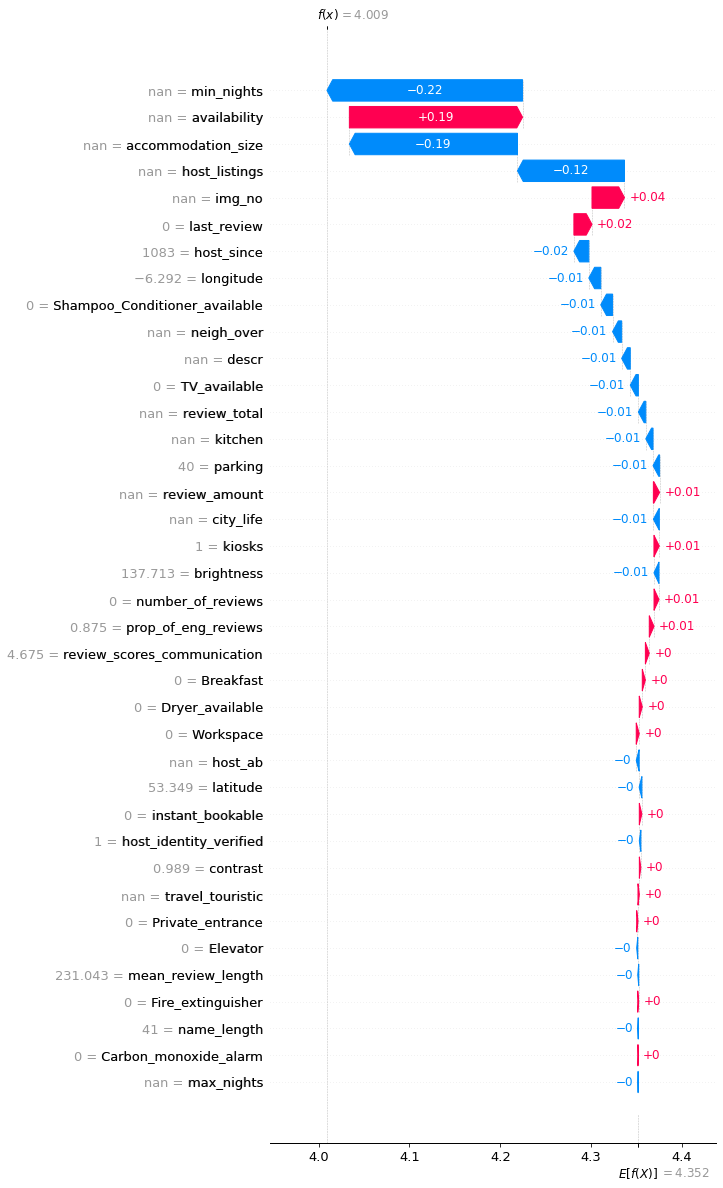

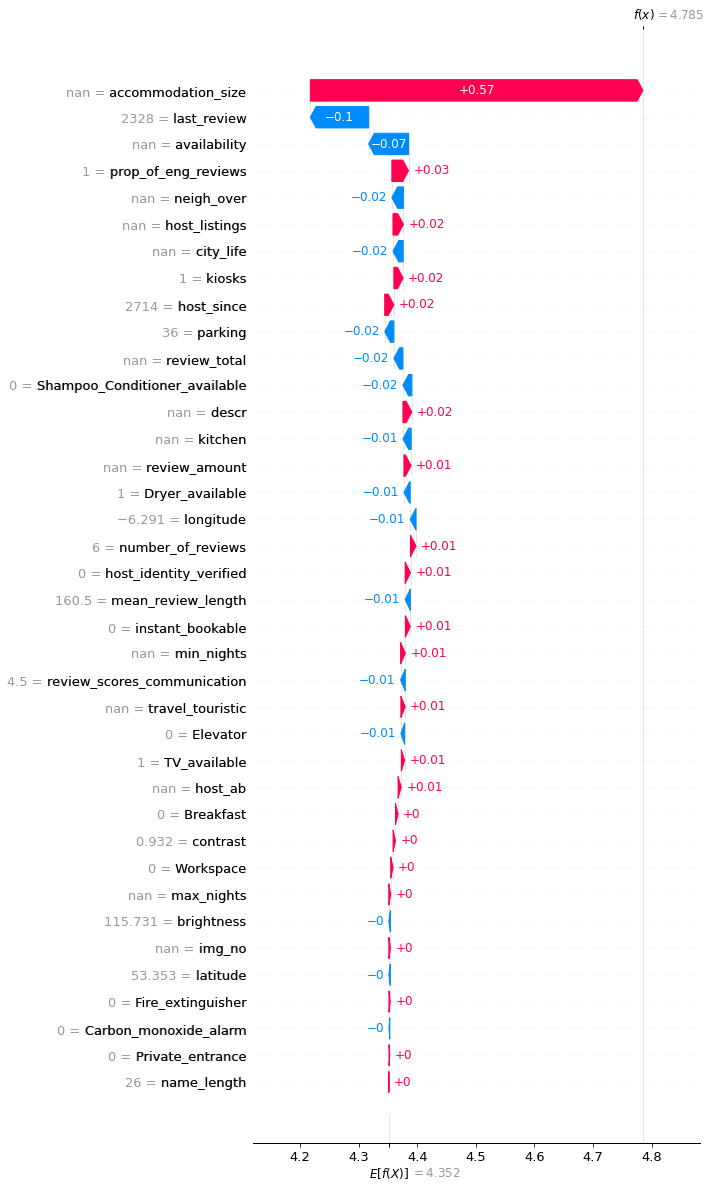

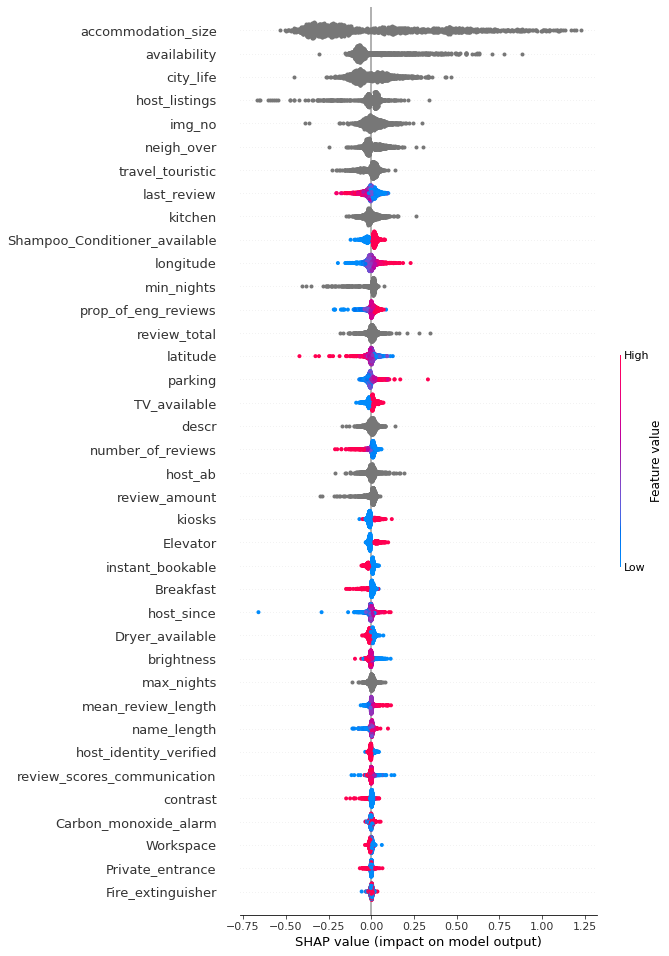

In [57]:
# PLOTS

#shap_values = get_aggr_shap(shap_values)

shap.plots.waterfall(shap_values[8], max_display = 50)                    
shap.plots.waterfall(shap_values[588], max_display = 50)

shap.plots.beeswarm(shap_values, max_display=50)

# Munich Prediction

In [17]:
from load_data_munich import * 

In [18]:
X_train, X_munich, y_train, y_munich = load_data_munich(for_dendro=False)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['Extra pillows and blankets', 'Free_parking', 'Luggage dropoff allowed', 'host_is_superhost', 'host_name_sounds_rare', 'host_name_sounds_west', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']
------------------------------
Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
44 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
PCA's built and correlated features dropped.
Due to insignificant t-tests we drop:
['Extra pillows and blankets', 'Free_parking', 

In [19]:
munich_pred = tf.data.Dataset.from_tensor_slices({"features": X_munich, "price": y_munich})
munich_dataset = munich_pred.take(len(X_munich))
munich_dataset = munich_dataset.map(transform)
munich_dataset = munich_dataset.batch(X_munich.shape[0])

In [57]:
y_pred = model.predict(munich_dataset)

In [67]:
y_pred.tolist()

[[4.099231243133545],
 [4.113947868347168],
 [4.077157020568848],
 [4.125732421875],
 [4.104047775268555],
 [4.111891269683838],
 [4.087020397186279],
 [4.096378326416016],
 [4.114830017089844],
 [4.112741470336914],
 [4.097346305847168],
 [4.110963344573975],
 [4.137533187866211],
 [4.086482524871826],
 [4.09985876083374],
 [4.084904670715332],
 [4.0958356857299805],
 [4.0970683097839355],
 [4.103675365447998],
 [4.053808212280273],
 [4.056393623352051],
 [4.080148696899414],
 [4.113138198852539],
 [4.098387718200684],
 [4.10746955871582],
 [4.112807273864746],
 [4.108095169067383],
 [4.130171298980713],
 [4.087714672088623],
 [4.122443199157715],
 [4.098168849945068],
 [4.014949798583984],
 [4.1205949783325195],
 [4.0967888832092285],
 [4.057497978210449],
 [4.124203681945801],
 [4.045701503753662],
 [4.100982666015625],
 [4.065613269805908],
 [4.097749710083008],
 [4.097742080688477],
 [4.099377632141113],
 [4.093262672424316],
 [4.090806484222412],
 [4.100017547607422],
 [4.0926313

In [20]:
model.evaluate(munich_dataset)

1/1 [==============================] - 0s 2ms/step - loss: 0.5652 - R_squared: -0.2910 - mse: 0.5652 - mae: 0.5869


[0.5651766061782837,
 -0.2910236120223999,
 0.5651766061782837,
 0.5869035720825195]

In [56]:
np.exp(0.5316057801246643)

1.7016626118995712